In [1]:
import torch
import numpy as np
%matplotlib inline

## Runge-Kutta

$$ h > 0 $$

$$ y_{n+1} = y_n + \frac{1}{6} ( k_1 + 2 k_2 + 2 k_3 + k_4 ) $$

$$ t_{n + 1} = t_n + h $$

\begin{align}
k_1 & = h f(t_n, y_n) \\
k_2 & = h f(t_n + \frac{h}{2}, y_n + \frac{k_1}{2}) \\
k_3 & = h f(t_n + \frac{h}{2}, y_n + \frac{k_2}{2}) \\
k_4 & = h f(t_n + h, y_n + k_3) \\
\end{align} 

In [196]:
def rk4(y, t, f, h):
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, t + h/2)
    k3 = h * f(y + k2 / 2, t + h/2)
    k4 = h * f(y + k3, t + h)
    
    y_next = y + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    t_next = t + h
    return y_next, t_next

In [197]:
def lorenz(a, b, c):
    def f(y, t):
        x, y, z = y
        dx = a * (y - x)
        dy = x * (b - z) - y
        dz = x*y - c * z
        return  t * np.array([dx, dy, dz])
    return f

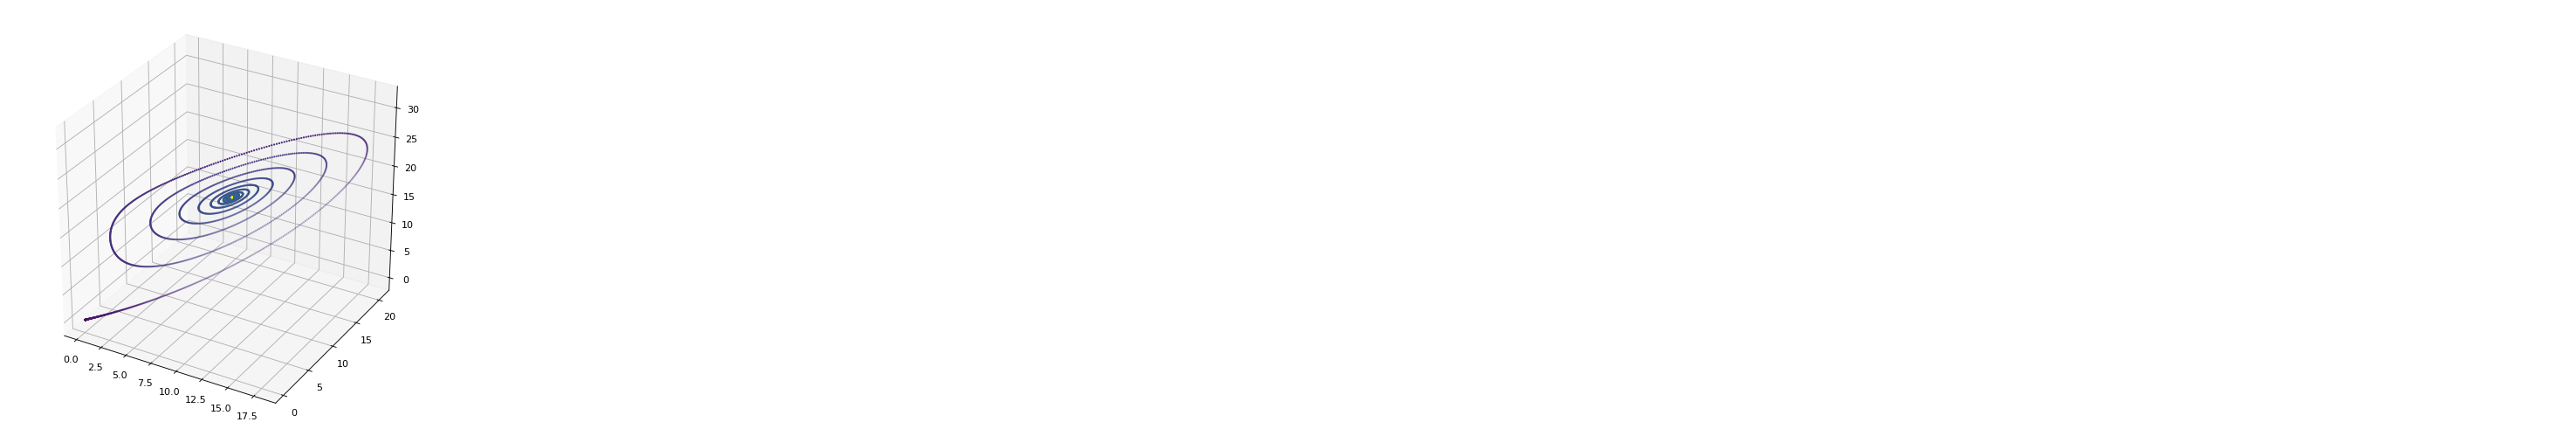

In [223]:
f = lorenz(20, 20, 5)
y = np.array([0.1, 0, 0])
t = 0
xs = []
ys = []
for i in range(10000):
    y, t = rk4(y, t, f, 1e-3)
    xs.append(t)
    ys.append(y)

from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')

X, Y, Z = zip(*ys)
ax.scatter3D(X, Y, Z, c=xs, s=1)

# Experiments

## Gaussian Mixture

In [107]:
import math
from scipy.stats import multivariate_normal

In [169]:
class Mixture:
    def __init__(self, dists, weights=None):
        if not weights:
            weights = np.ones(len(dists)) / len(dists)
        self.weights = weights
        self.dists = dists
    
    def rvs(self, n=1):
        counts = np.random.multinomial(n, self.weights)
        samples = []
        for k, p in zip(counts, self.dists):
            samples.extend([ p.rvs() for _ in range(k) ])
        return samples
    
    def pdf(self, x):
        pdf = np.asarray([dist.pdf(x) for dist in self.dists])
        pdf = pdf.transpose([1, 2, 0])
        print(self.weights.shape, pdf.shape)
        return np.dot(pdf, self.weights)

In [180]:
nb_gaussians = 10
spread = 1.5*nb_gaussians
gaussians = []
for i in range(nb_gaussians):
    u = (i / nb_gaussians) * 2 * math.pi
    g = multivariate_normal([spread * math.cos(u), spread * math.sin(u)], np.eye(2))
    gaussians.append(g)

m = Mixture(gaussians)

n_samples = 1000
samples = [ m.rvs()[0] for i in range(n_samples)]

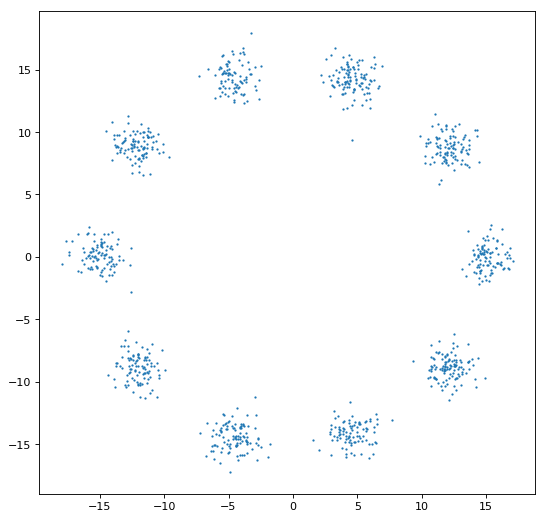

In [181]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8), dpi=80)
ax = fig.add_subplot(111)

xs, ys = zip(*samples)
ax.scatter(xs, ys, s=1)

(10,) (338, 338, 10)


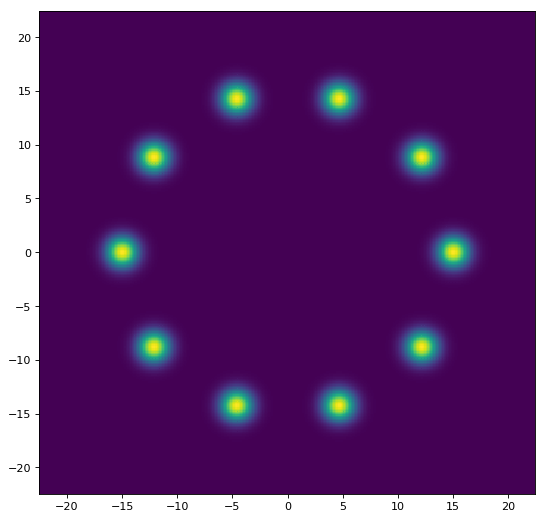

In [194]:
res = 2 / (spread)
extent = spread * 1.5
x, y = np.mgrid[-extent:extent:res, -extent:extent:res]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = m
pdf = rv.pdf(pos)

fig = plt.figure(figsize=(8, 8), dpi=80)
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, pdf)

## FFJORD

### Algorithm

**Inputs**:
dynamics $f_\theta$,
start time $t_0$,
stop time, $t_1$,
minibatch $\mathbf{x}$

**Adjoint Method**:
$$ L(\mathbf{z}(t_1)) = L \left( \int^{t_1}_{t_0} f(\mathbf{z}(t), t; \theta) dt \right) $$

$$ \frac{dL}{d\theta} = - \int^{t_0}_{t_1} \left( \frac{\partial L}{\partial \mathbf{z}(t)} \right)^T \frac{\partial f(\mathbf{z}(t), t; \theta)}{ \partial \theta} dt$$

$$ \text{adjoint state of ODE}
 :
= - \frac{\partial L}{ \partial \mathbf{z}(t) } $$

In [201]:
class FFJORD:
    def __init__(self, dynamics):
        self.f = dynamics
    
    def forward(self, start_time, stop_time, x):
        epsilon = sample_unit_var(x.shape)
        def f_aug(aug_state, t):
            z_t, log_p_t = aug_state
            f_t = self.f(z_t, t)
            
            # Estimate Tr(df/dz) with \eps df/dz \eps
            g = epsilon.T * df_dz
            Tr = torch.matmul()
            return [f_t, -Tr]
        
        z, delta_logp = odeint(f_aug, [x, np.zeros(D)], start_time, stop_time)
        log_prob_x = np.log(z_0.pdf(z)) - delta_logp
        return log_px
    
    def backward(self, grad_output):
        def f_aug(aug_state, t, theta):
            z_t, a_t, _, _ = aug_state
            
        zt0, dldzt0, dLdtheta, dLdt0 = odesolve(s0)
        pass

In [ ]:
# VJP := matrix-free vector-Jacobian product functions 

def grad_odeint_all(yt, func, y0, t, func_args, **kwargs):
    T, D = np.shape(yt)
    flat_args, unflatten = flatten(func_args)
    
    def flat_func(y, t, flat_args):
        return func(y, t, *unflatten(flat_args))
    
    def unpack(x):
        #        y        vjp_y    vjp_t     vjp_args
        return x[0:D], x[D:2*D], x[2*D], x[2*D+1:]
    
    def augmented_dynamics(augmented_state, t, flat_args):
        y, vjp_y, _, _, = unpack(augmented_state)
        vjp_all, dy_dt = make_vjp(flat_func, argnum=(1, 2, 3))(y, t, flat_args)
        vjp_y, vjp_t, vjp_args = vjpg_all(-vjp_y)
        return np.hstack((dy_dt, vjp_y, vjp_t, vjp_args))
    
    def vjp_all(g, **kwargs):
        vjp_y = g[-1, :]
        vjp_t0 = 0
        time_vjp_list = []
        vjp_args = np.zeros(np.size(flat_args))
        
        for i in range(T-1, 0, -1):
            # Compute effect of moving current time
            vjp_cur_t = np.dot(func(yt[i, :], t[i], *func_args), g[i, :])
            time_vjp_list.append(vjp_cur_t)
            
            aug_y0 = np.hstack((yt[i, :], vjp_y, vjp_t0, vjp_args))
            aug_ans = odeint(augmented_dynamics, aug_y0, np.array([t[i], t[i-1]]), tuple((flat_args,)), **kwargs)
            _, vjp_y, vjp_t0, vjp_args = unpack(aug_ans[1])
            
            # Add gradient from current output
            vjp_y = vjp_y + g[i - 1, :]
        
        time_vjp_list.append(vjp_t0)
        vjp_times = np.hstack(time_vjp_list)[::-1]
        
        return None, vjp_y, vjp_times, unflatten(vjp_args)
    return vjp_all

def grad_arg